<a href="https://colab.research.google.com/github/20134571/20134571.github.io/blob/main/Ungrouped_Features_Baseline_ML1109_With_SMOTE_1909AJB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        Gender      Customer Type  Age   Type of Travel     Class  \
0         male     loyal customer   13  personal travel  eco plus   
1         male  disloyal customer   25  business travel  business   
2       female     loyal customer   26  business travel  business   
3       female     loyal customer   25  business travel  business   
4         male     loyal customer   61  business travel  business   
...        ...                ...  ...              ...       ...   
129875    male  disloyal customer   34  business travel  business   
129876    male     loyal customer   23  business travel  business   
129877  female     loyal customer   17  personal travel       eco   
129878    male     loyal customer   14  business travel  business   
129879  female     loyal customer   42  personal travel       eco   

        Flight Distance  Inflight wifi service  \
0                   460                      3   
1                   235                      3   
2                  11

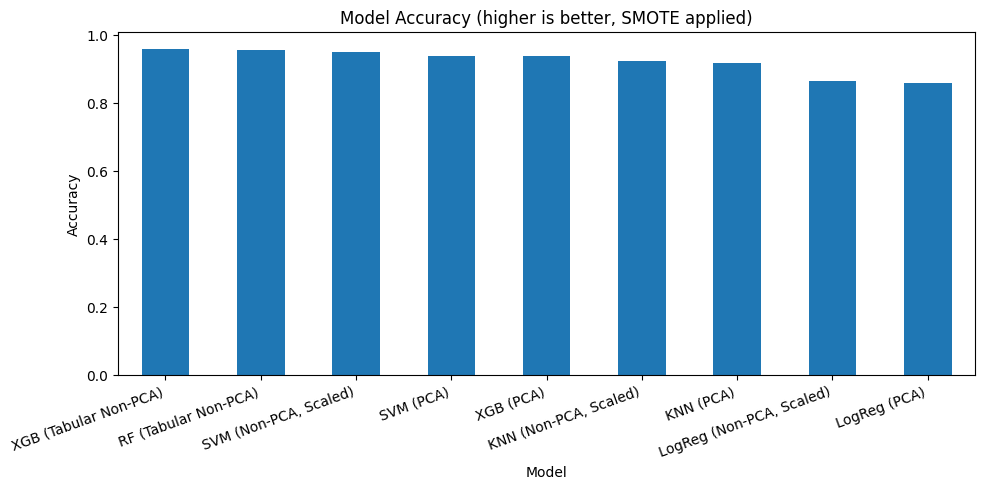

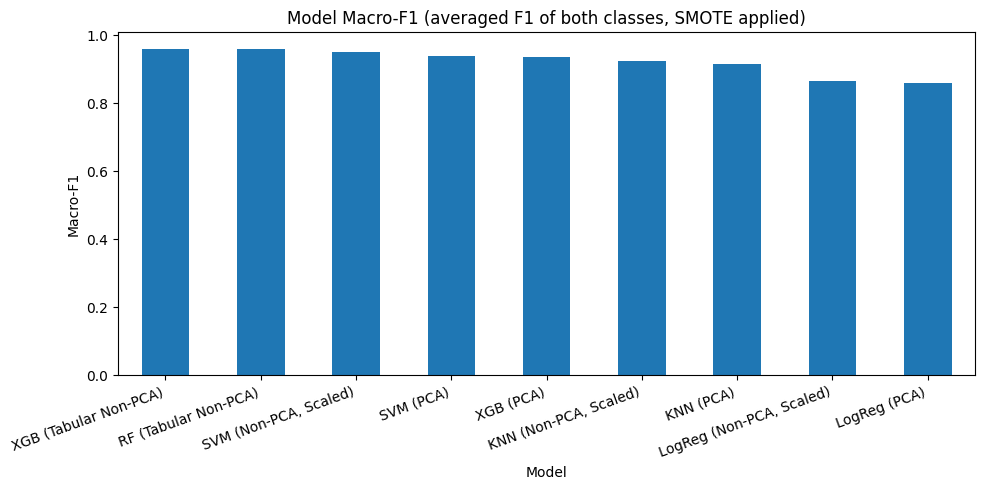

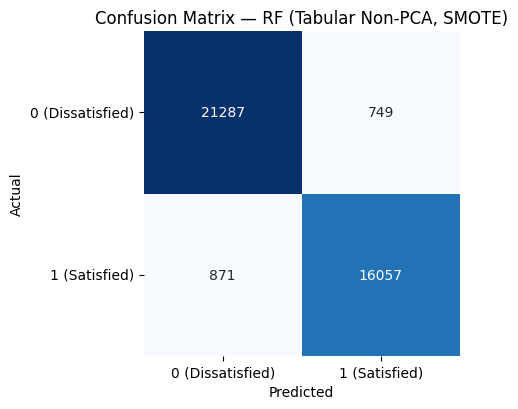

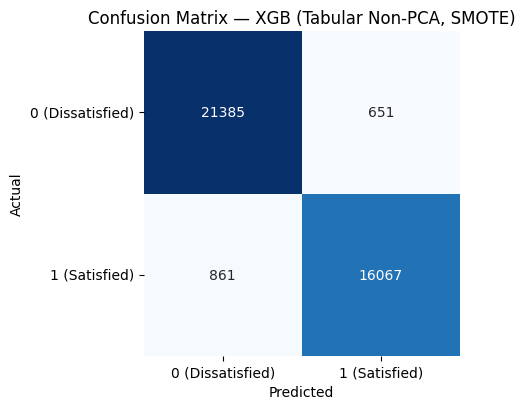

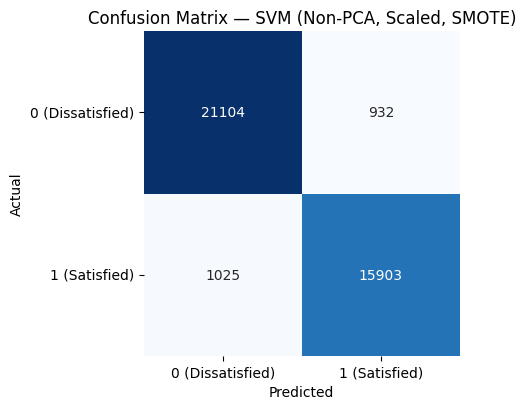

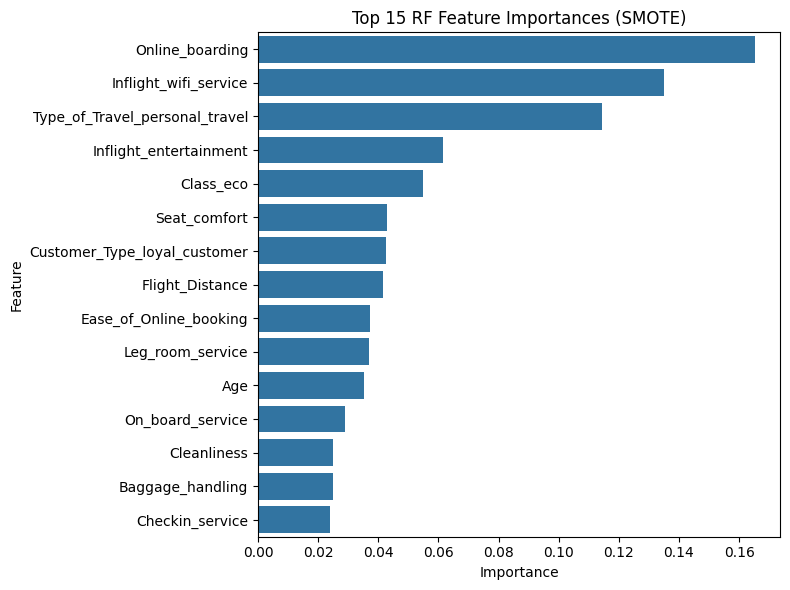


Top RF features:
                            Feature  Importance
7                  Online_boarding    0.165338
2            Inflight_wifi_service    0.135039
21  Type_of_Travel_personal_travel    0.114557
9           Inflight_entertainment    0.061378
22                       Class_eco    0.054898
8                     Seat_comfort    0.042744
20    Customer_Type_loyal_customer    0.042481
1                  Flight_Distance    0.041542
4           Ease_of_Online_booking    0.037341
11                Leg_room_service    0.036879
0                              Age    0.035329
10                On_board_service    0.028820
15                     Cleanliness    0.024981
12                Baggage_handling    0.024977
13                 Checkin_service    0.024102


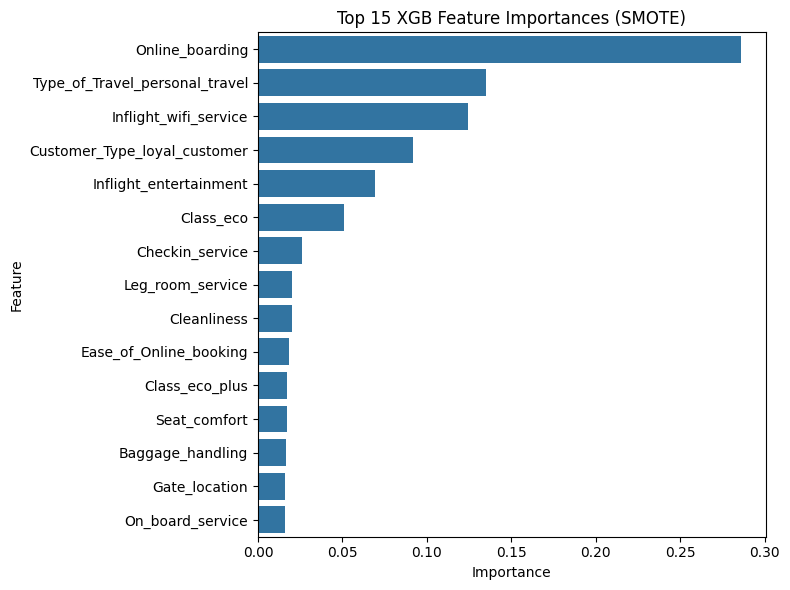


Top XGB features:
                            Feature  Importance
7                  Online_boarding    0.286095
21  Type_of_Travel_personal_travel    0.135006
2            Inflight_wifi_service    0.123995
20    Customer_Type_loyal_customer    0.091762
9           Inflight_entertainment    0.069078
22                       Class_eco    0.050687
13                 Checkin_service    0.026308
11                Leg_room_service    0.019988
15                     Cleanliness    0.019828
4           Ease_of_Online_booking    0.018320
23                  Class_eco_plus    0.017176
8                     Seat_comfort    0.017149
12                Baggage_handling    0.016486
5                    Gate_location    0.016059
10                On_board_service    0.015970


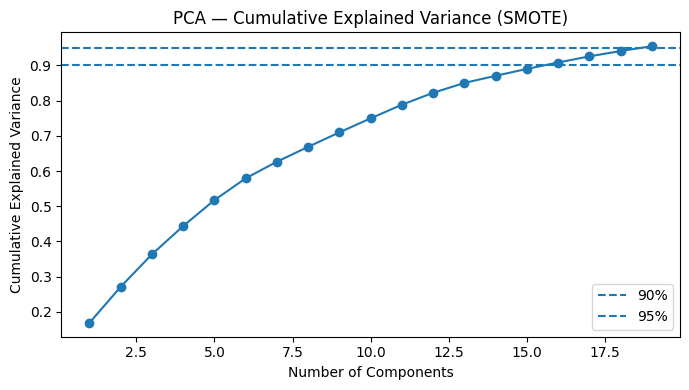

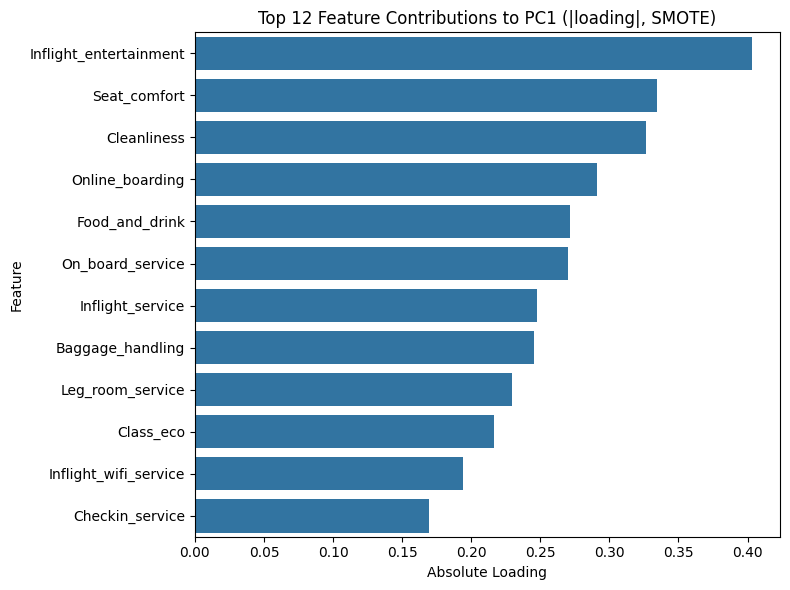

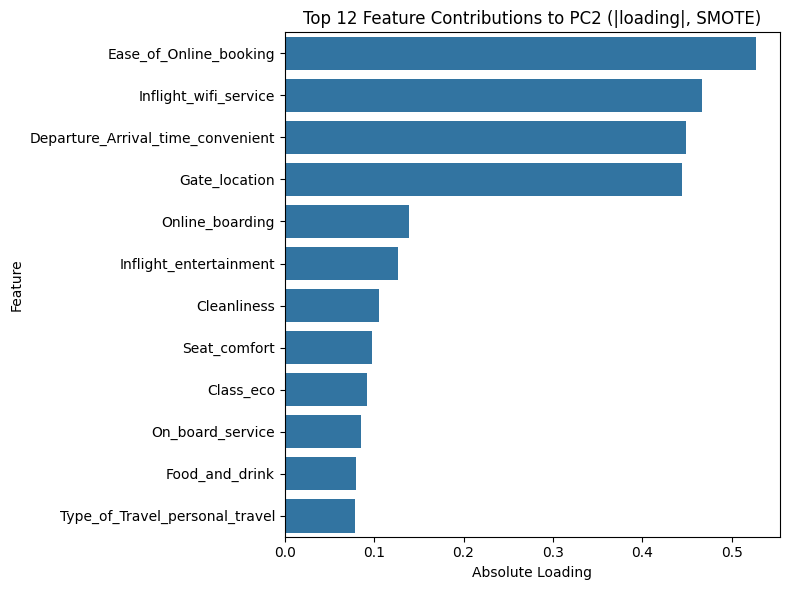

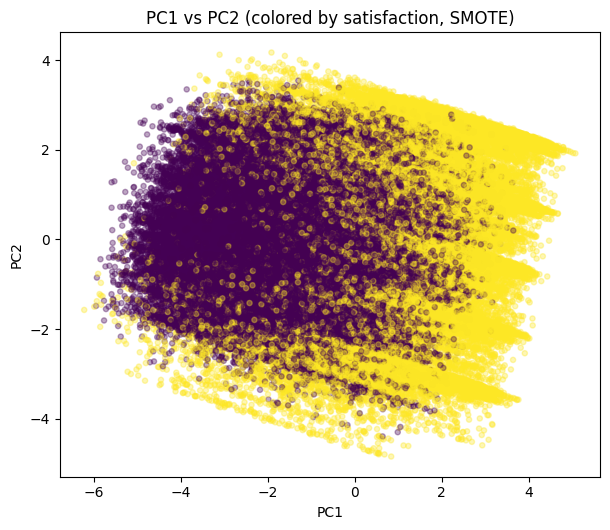

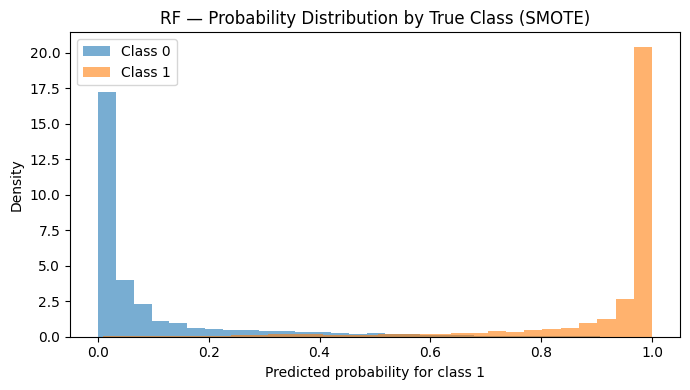

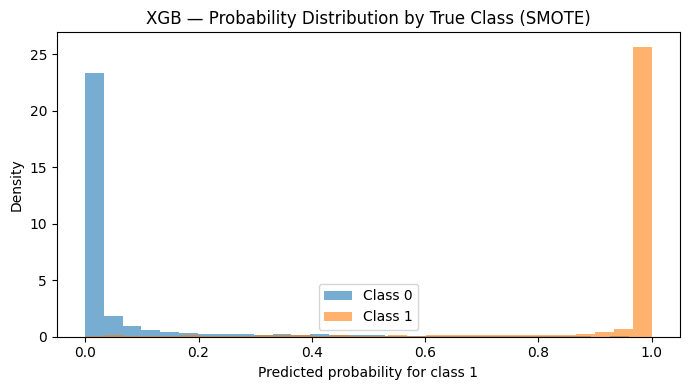

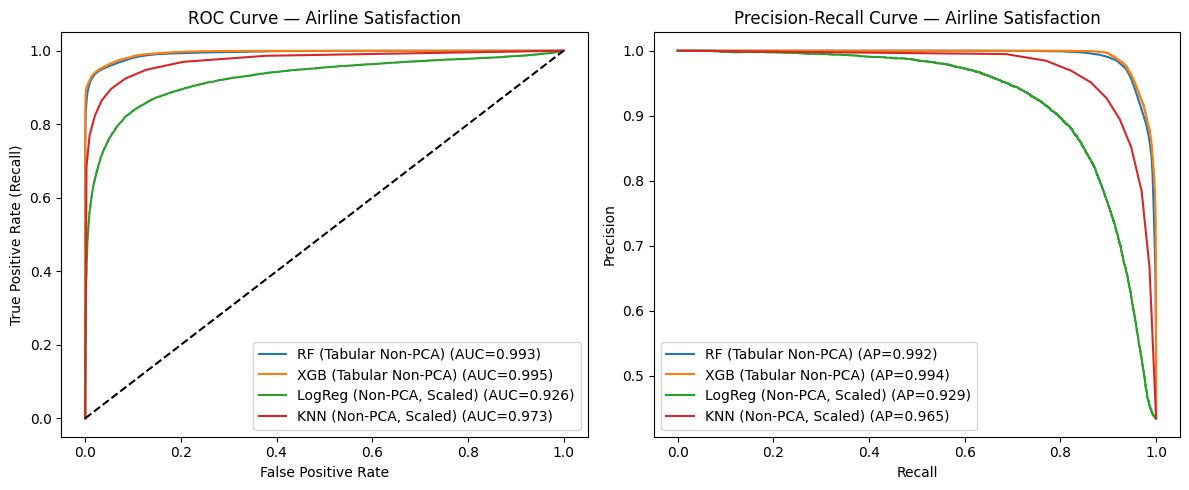

In [2]:

# -*- coding: utf-8 -*-
"""
Created on Thu Sep 11 08:05:47 2025

@author: heidi
"""

# ============================ STABILITY (Windows/Spyder) ============================
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ============================ Imports ============================
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# SMOTE for synthetic data
from imblearn.over_sampling import SMOTE

# XGBoost (optional)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("ℹ️ Skipping XGBoost (import failed):", e)

# ============================ Config ============================
N_JOBS_PAR = 2          # keep modest to avoid freezes
PCA_VARIANCE = 0.95     # keep ~95% variance for PCA

# ============================ 1) Load & basic clean ============================
import pandas as pd
from google.colab import files
url = "https://raw.githubusercontent.com/20134571/AISKILLSET/main/airline_satisfaction_mitigation_arrival_cleaned.csv"
df = pd.read_csv(url)
print (df)

print(df.head())

#df = pd.read_csv("airline_satisfaction_cleaned_ungrouped.csv")
df = df.dropna().reset_index(drop=True)

target_col = "satisfaction"
drop_cols = ["Unnamed: 0", "id", "Arrival Delay in Minutes"]  # adjust if you want to keep arrival delay

# ============================ 2) Build X, y ============================
X = df.drop(columns=[c for c in drop_cols if c in df.columns] + [target_col]).copy()
y = df[target_col].copy()

# ---- Ensure numeric features: one-hot encode only if needed ----
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if cat_cols:
    preview = cat_cols[:10]
    print(f"One-hot encoding {len(cat_cols)} categorical columns: {preview}{' ...' if len(cat_cols)>10 else ''}")
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
else:
    print("No categorical columns detected — skipping one-hot encoding.")

# ---- Sanitize column names for XGBoost safety ----
def _sanitize(s: str) -> str:
    s = str(s)
    s = re.sub(r"[^\w]+", "_", s)    # replace non-alphanumerics with _
    s = re.sub(r"_+", "_", s).strip("_")
    return s

X.columns = [_sanitize(c) for c in X.columns]
print(f"Features after encoding: {X.shape[1]}")

# ============================ 3) Unified split (shared by all models) ============================
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train_tab = X.iloc[train_idx].copy()
X_test_tab  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()

# ============================ 3b) Apply SMOTE to training set ============================
print("Original training set class distribution:", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_tab_res, y_train_res = smote.fit_resample(X_train_tab, y_train)

print("After SMOTE class distribution:", pd.Series(y_train_res).value_counts().to_dict())

# ============================ 3c) Scaled & PCA views ============================
scaler = StandardScaler().fit(X_train_tab_res)
X_train_scaled = scaler.transform(X_train_tab_res)
X_test_scaled  = scaler.transform(X_test_tab)

pca = PCA(n_components=PCA_VARIANCE, random_state=42).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"PCA reduced features:    {X_train_pca.shape[1]}")

# ============================ 4) Train models (both PCA & non-PCA) ============================

def summarize(y_true, y_pred, name):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Prec_0": rep["0"]["precision"], "Rec_0": rep["0"]["recall"], "F1_0": rep["0"]["f1-score"],
        "Prec_1": rep["1"]["precision"], "Rec_1": rep["1"]["recall"], "F1_1": rep["1"]["f1-score"],
        "MacroF1": (rep["0"]["f1-score"] + rep["1"]["f1-score"]) / 2,
        "WeightedF1": rep["weighted avg"]["f1-score"],
    }

rows = []

# ---------- Non-PCA (scaled) ----------
knn_np = KNeighborsClassifier(n_neighbors=9).fit(X_train_scaled, y_train_res)
rows.append(summarize(y_test, knn_np.predict(X_test_scaled), "KNN (Non-PCA, Scaled)"))

logreg_np = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_scaled, y_train_res)
rows.append(summarize(y_test, logreg_np.predict(X_test_scaled), "LogReg (Non-PCA, Scaled)"))

svm_np = SVC(kernel='rbf', random_state=42).fit(X_train_scaled, y_train_res)
rows.append(summarize(y_test, svm_np.predict(X_test_scaled), "SVM (Non-PCA, Scaled)"))

# ---------- PCA ----------
knn_pca = KNeighborsClassifier(n_neighbors=9).fit(X_train_pca, y_train_res)
rows.append(summarize(y_test, knn_pca.predict(X_test_pca), "KNN (PCA)"))

logreg_pca = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_pca, y_train_res)
rows.append(summarize(y_test, logreg_pca.predict(X_test_pca), "LogReg (PCA)"))

svm_pca = SVC(kernel='rbf', random_state=42).fit(X_train_pca, y_train_res)
rows.append(summarize(y_test, svm_pca.predict(X_test_pca), "SVM (PCA)"))

# ---------- Random Forest (NON-PCA ONLY) ----------
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=N_JOBS_PAR)
rf.fit(X_train_tab_res, y_train_res)
rows.append(summarize(y_test, rf.predict(X_test_tab), "RF (Tabular Non-PCA)"))

# ---------- XGBoost (both Tabular and PCA) ----------
if HAS_XGB:
    # Balanced dataset after SMOTE -> scale_pos_weight = 1
    xgb_tab = XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", tree_method="hist",
        n_estimators=500, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=1, random_state=42, n_jobs=N_JOBS_PAR
    )
    xgb_tab.fit(X_train_tab_res, y_train_res)
    rows.append(summarize(y_test, xgb_tab.predict(X_test_tab), "XGB (Tabular Non-PCA)"))

    xgb_pca = XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", tree_method="hist",
        n_estimators=500, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=1, random_state=42, n_jobs=N_JOBS_PAR
    )
    xgb_pca.fit(X_train_pca, y_train_res)
    rows.append(summarize(y_test, xgb_pca.predict(X_test_pca), "XGB (PCA)"))

# ============================ 5) Results table ============================
df_results = pd.DataFrame(rows).set_index("Model").round(3)
print("\n=== Results (Both PCA & Non-PCA; RF Non-PCA only, with SMOTE) ===")
print(df_results.sort_values(["Accuracy", "MacroF1"], ascending=False))

# (Optional) save to CSV
# df_results.to_csv("results_pca_vs_nonpca_smote.csv")


# ========================= VISUALIZATIONS =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------- 1) Leaderboard: Accuracy & MacroF1 ----------
df_plot = df_results[["Accuracy", "MacroF1"]].copy().sort_values("Accuracy", ascending=False)
plt.figure(figsize=(10,5))
df_plot["Accuracy"].plot(kind="bar")
plt.title("Model Accuracy (higher is better, SMOTE applied)")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
df_plot["MacroF1"].plot(kind="bar")
plt.title("Model Macro-F1 (averaged F1 of both classes, SMOTE applied)")
plt.ylabel("Macro-F1")
plt.xticks(rotation=20, ha="right")
plt.tight_layout(); plt.show()

# ---------- 2) Confusion matrices for top performers ----------
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.xticks([0.5,1.5], ["0 (Dissatisfied)","1 (Satisfied)"])
    plt.yticks([0.5,1.5], ["0 (Dissatisfied)","1 (Satisfied)"], rotation=0)
    plt.tight_layout(); plt.show()

plot_cm(y_test, rf.predict(X_test_tab), "Confusion Matrix — RF (Tabular Non-PCA, SMOTE)")
try:
    plot_cm(y_test, xgb_tab.predict(X_test_tab), "Confusion Matrix — XGB (Tabular Non-PCA, SMOTE)")
except NameError:
    pass
plot_cm(y_test, svm_np.predict(X_test_scaled), "Confusion Matrix — SVM (Non-PCA, Scaled, SMOTE)")

# ---------- 3) Feature importances (RF & XGB) ----------
rf_imp = (pd.DataFrame({"Feature": X_train_tab_res.columns, "Importance": rf.feature_importances_})
          .sort_values("Importance", ascending=False).head(15))
plt.figure(figsize=(8,6))
sns.barplot(data=rf_imp, x="Importance", y="Feature")
plt.title("Top 15 RF Feature Importances (SMOTE)")
plt.tight_layout(); plt.show()
print("\nTop RF features:\n", rf_imp)

try:
    xgb_imp = (pd.DataFrame({"Feature": X_train_tab_res.columns, "Importance": xgb_tab.feature_importances_})
               .sort_values("Importance", ascending=False).head(15))
    plt.figure(figsize=(8,6))
    sns.barplot(data=xgb_imp, x="Importance", y="Feature")
    plt.title("Top 15 XGB Feature Importances (SMOTE)")
    plt.tight_layout(); plt.show()
    print("\nTop XGB features:\n", xgb_imp)
except NameError:
    pass

# ---------- 4) PCA visuals (explained variance, loadings, scatter) ----------
cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.axhline(0.90, linestyle='--', label='90%')
plt.axhline(0.95, linestyle='--', label='95%')
plt.xlabel("Number of Components"); plt.ylabel("Cumulative Explained Variance")
plt.title("PCA — Cumulative Explained Variance (SMOTE)"); plt.legend(); plt.tight_layout(); plt.show()

loadings = pd.DataFrame(
    pca.components_.T,
    index=X_train_tab_res.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
for pc in ["PC1", "PC2"]:
    if pc in loadings.columns:
        top = loadings[pc].abs().sort_values(ascending=False).head(12)
        plt.figure(figsize=(8,6))
        sns.barplot(x=top.values, y=top.index, orient="h")
        plt.title(f"Top {len(top)} Feature Contributions to {pc} (|loading|, SMOTE)")
        plt.xlabel("Absolute Loading"); plt.ylabel("Feature")
        plt.tight_layout(); plt.show()

X_scaled_all = scaler.transform(X)
PC_all = pca.transform(X_scaled_all)
plt.figure(figsize=(6.2,5.4))
plt.scatter(PC_all[:,0], PC_all[:,1], c=y, alpha=0.35, s=14)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PC1 vs PC2 (colored by satisfaction, SMOTE)")
plt.tight_layout(); plt.show()

# ---------- 5) (Optional) Probability histograms ----------
def prob_hist(model, X_te, y_te, title):
    if not hasattr(model, "predict_proba"):
        return
    p = model.predict_proba(X_te)[:,1]
    plt.figure(figsize=(7,4))
    plt.hist(p[y_te==0], bins=30, alpha=0.6, label="Class 0", density=True)
    plt.hist(p[y_te==1], bins=30, alpha=0.6, label="Class 1", density=True)
    plt.xlabel("Predicted probability for class 1"); plt.ylabel("Density")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

prob_hist(rf, X_test_tab, y_test, "RF — Probability Distribution by True Class (SMOTE)")
try:
    prob_hist(xgb_tab, X_test_tab, y_test, "XGB — Probability Distribution by True Class (SMOTE)")
except NameError:
    pass

#====================ROC Curve and PR Curve====================#

# def plot_roc_pr(models, X_test, y_test, title_suffix=""):
#   plt.figure(figsize=(12,5))



#   # ---- ROC curve ----
#   plt.subplot(1,2,1)
#   for name, model, X in models:
#       if hasattr(model, "predict_proba"):
#           y_score = model.predict_proba(X)[:,1]
#       elif hasattr(model, "decision_function"):
#           y_score = model.decision_function(X)
#       else:
#           continue

#       fpr, tpr, _ = roc_curve(y_test, y_score)
#       roc_auc = auc(fpr, tpr)
#       plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

#   plt.plot([0,1],[0,1],"k--")
#   plt.xlabel("False Positive Rate")
#   plt.ylabel("True Positive Rate (Recall)")
#   plt.title(f"ROC Curve {title_suffix}")
#   plt.legend(loc="lower right")

#   # ---- Precision-Recall curve ----
#   plt.subplot(1,2,2)
#   for name, model, X in models:
#       if hasattr(model, "predict_proba"):
#           y_score = model.predict_proba(X)[:,1]
#       elif hasattr(model, "decision_function"):
#           y_score = model.decision_function(X)
#       else:
#           continue

#       precision, recall, _ = precision_recall_curve(y_test, y_score)
#       ap = average_precision_score(y_test, y_score)
#       plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

#   plt.xlabel("Recall")
#   plt.ylabel("Precision")
#   plt.title(f"Precision-Recall Curve {title_suffix}")
#   plt.legend(loc="lower left")

#   plt.tight_layout()
#   plt.show()


# # === Call for your best models ===
# models_to_plot = [
#   ("RF (Tabular Non-PCA)", rf, X_test_tab),
# ]

# try:
#   models_to_plot.append(("XGB (Tabular Non-PCA)", xgb_tab, X_test_tab))
# except NameError:
#   pass

# models_to_plot += [
#   ("LogReg (Non-PCA, Scaled)", logreg_np, X_test_scaled),
#   ("KNN (Non-PCA, Scaled)", knn_np, X_test_scaled),
#   # SVM must be trained with probability=True to use here
# ]

# plot_roc_pr(models_to_plot, y_test, title_suffix="— Airline Satisfaction")
def plot_roc_pr(models, y_test, title_suffix=""):
    plt.figure(figsize=(12,5))

    # ---- ROC curve ----
    plt.subplot(1,2,1)
    for name, model, X in models:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)[:,1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X)
        else:
            continue

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve {title_suffix}")
    plt.legend(loc="lower right")

    # ---- Precision-Recall curve ----
    plt.subplot(1,2,2)
    for name, model, X in models:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)[:,1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X)
        else:
            continue

        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve {title_suffix}")
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

  plot_roc_pr(models_to_plot, y_test, title_suffix="— Airline Satisfaction")
